### CNN with a fine-tuned vgg16 model

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-05-28 15:29:58.249785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-28 15:29:59.037336: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 15:29:59.037941: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-28 15:29:59.038556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-28 15:29:59.048424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import plot_confusion_matrix as pcm
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-05-28 15:30:12.330111: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-28 15:30:12.330237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 15:30:12.330336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.635GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-28 15:30:12.330359: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-28 15:30:12.330374: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-28 15:30:12.330382: I tensorflow/stream_executor/platform

In [4]:
# We import the pre-trained VGG16 model from Keras
## This model can classify images in 1000 categories. However we will only be using this model to categorize cats and dogs.
### In that case we will have to fine-tuned this model. That means change a few layers in order to use it for our application 

vgg16_model=tf.keras.applications.vgg16.VGG16()

2023-05-28 15:30:12.374504: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-28 15:30:12.374670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 15:30:12.374792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.635GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-28 15:30:12.374818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-28 15:30:12.374839: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-28 15:30:12.374848: I tensorflow/stream_executor/platform

In [5]:
# checking the model

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# checking out the type of vgg16 model
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [7]:
# For now we are going to work with sequential models only. Therefore we are going to convert the functional model to a sequential one.

model = Sequential()
for layer in vgg16_model.layers[:-1]:   #we have replicated the entire vgg16_model (excluding the output layer) to a new Sequential model
    model.add(layer)

In [8]:
for layer in model.layers:
    layer.trainable = False     # we freezes the weights and other trainable parameters in each layer so that they will not be trained or updated

The reason we don't want to retrain these layers is because, as mentioned earlier, cats and dogs were already included in the original ImageNet library. So, VGG16 already does a nice job at classifying these categories. We only want to modify the model such that the output layer understands only how to classify cats and dogs and nothing else. Therefore, we don't want any re-training to occur on the earlier layers.

In [9]:
# Lastly we add our new output layer, consisting of only 2 nodes that correspond to cat and dog.
model.add(Dense(units=2, activation='softmax'))

In [10]:
# we check the new model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [11]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
#We then create variables for which the the paths to the train, valid, and test data directories are assigned

train_path = '../data/dogs-vs-cats/train'
valid_path = '../data/dogs-vs-cats/valid'
test_path = '../data/dogs-vs-cats/test'

In [13]:
#We use Keras' ImageDataGenerator class to create batches of data from the train, valid, and test directories
## ImageDataGenerator.flow_from_directory() creates a DirectoryIterator, which generates batches of normalized tensor image data from the respective data directories.
### To flow_from_directory(), we first specify the path for the data. We then specify the target_size of the images, which will resize all images to the specified size. The size we specify here is determined by the input size that the neural network expects.
#### The classes parameter expects a list that contains the underlying class names, and lastly, we specify the batch_size.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1010 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [14]:
# we train the model
## we train the model the same as the previos cnn but with 5 epochs
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

Epoch 1/5


2023-05-28 15:30:13.914095: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-28 15:30:13.914428: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4099895000 Hz
2023-05-28 15:30:14.274135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-28 15:30:14.421797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-28 15:30:15.131820: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-05-28 15:30:15.176658: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-05-28 15:30:16.021714: I tensorflow/stream

101/101 - 18s - loss: 0.7037 - accuracy: 0.7129 - val_loss: 0.2210 - val_accuracy: 0.9150


2023-05-28 15:30:31.323457: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:31.409617: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:31.523476: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 2/5


2023-05-28 15:30:31.609374: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:31.696007: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:31.782289: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:31.869359: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:31.955247: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:32.041384: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17

101/101 - 11s - loss: 0.1338 - accuracy: 0.9426 - val_loss: 0.1312 - val_accuracy: 0.9550


2023-05-28 15:30:41.961135: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:42.075711: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 3/5


2023-05-28 15:30:42.161702: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:42.248274: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:42.335830: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:42.422148: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:42.508483: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:42.594916: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17

101/101 - 11s - loss: 0.0802 - accuracy: 0.9693 - val_loss: 0.0995 - val_accuracy: 0.9600


2023-05-28 15:30:52.562756: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:52.676635: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:52.762533: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 4/5


2023-05-28 15:30:52.850515: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:52.937808: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:53.024434: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:53.111070: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:53.197906: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:30:53.287482: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17

101/101 - 11s - loss: 0.0561 - accuracy: 0.9832 - val_loss: 0.0809 - val_accuracy: 0.9600


2023-05-28 15:31:03.104590: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:31:03.190704: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 5/5


2023-05-28 15:31:03.307376: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:31:03.393510: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:31:03.480440: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:31:03.569132: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:31:03.655565: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:31:03.742401: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17

101/101 - 11s - loss: 0.0438 - accuracy: 0.9851 - val_loss: 0.0733 - val_accuracy: 0.9650


2023-05-28 15:31:13.764652: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:31:13.851901: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Looking at the results from training, we can see just after 5 epochs, we have some pretty outstanding results, especially when you compare it to the results we got from our original model.

Our accuracy starts off at 88% and goes over 99% in just 5 epochs. Similarly, our validation accuracy increases from 95% to 98%.

The most noticeable improvement is that this model is generalizing very well to the validation data, unlike the CNN we build from scratch previously.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

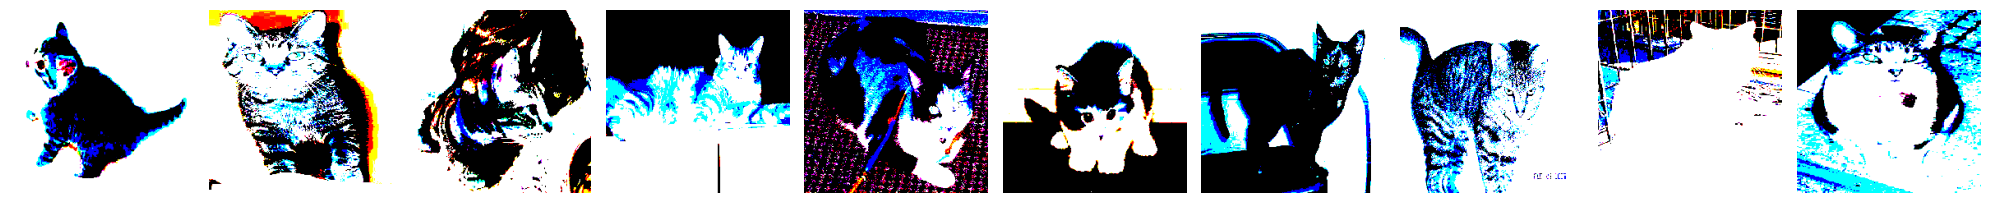

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
# Check the test data is ok
import plotImages as pltI

test_imgs, test_labels = next(test_batches)
pltI.plotImages(test_imgs)
print(test_labels)

In [16]:
# we call model.predicto to have the model predict on test data

predictions=model.predict(x=test_batches, steps=len(test_batches), verbose=0)

2023-05-28 15:42:03.908895: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:42:04.013750: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:42:04.117870: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:42:04.221231: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:42:04.311173: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17G (2325151744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-05-28 15:42:04.392563: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.17

Confusion matrix, without normalization
[[50  0]
 [ 2 48]]


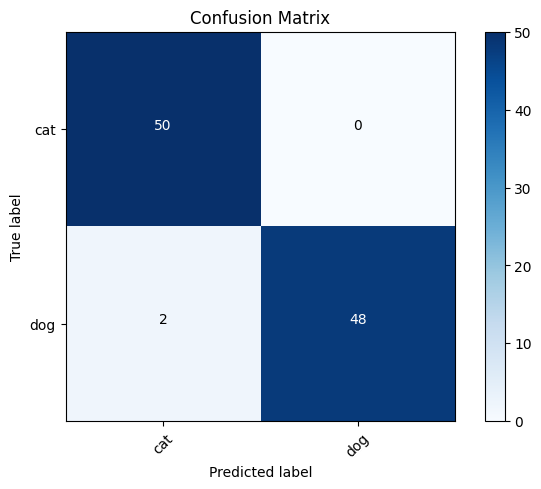

In [17]:
import plot_confusion_matrix as pcm

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']
pcm.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')